<a href="https://colab.research.google.com/github/Kargin-Alexey/study_projects/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST
## Введение
MNIST (сокращение от «Modified National Institute of Standards and Technology») — объёмная база данных образцов рукописного написания цифр. База данных является стандартом, предложенным Национальным институтом стандартов и технологий США с целью калибрации и сопоставления методов распознавания изображений с помощью машинного обучения.    

База данных была создана после переработки оригинального набора чёрно-белых образцов размером 20x20 пикселей NIST. Создатели базы данных NIST, в свою очередь, использовали набор образцов из Бюро переписи населения США, к которому были добавлены ещё тестовые образцы, написанные студентами американских университетов. Образцы из набора NIST были нормализированы, прошли сглаживание и приведены к серому полутоновому изображению размером 28x28 пикселей.

База данных MNIST содержит 60000 изображений для обучения и 10000 изображений для тестирования.

Производились многочисленные попытки достичь минимальной ошибки после обучения по базе данных MNIST, которые обсуждались в научной литературе. Рекордные результаты указывались в публикациях, посвящённых использованию свёрточных нейронных сетей, уровень ошибки был доведён до 0,23 %. Сами создатели базы данных предусмотрели несколько методов тестирования. В оригинальной работе указывается, что использование метода опорных векторов позволяет достичь уровня ошибки 0,8 %.

__Цель:__ Поэкспериментировать классифицировать озображения с помощью различных алгоритмов МО. Попробовать улучшить качество классификации с помощью обработки изображений.

## Выгрузка данных
Сделаем ипорт библиотек и данных. Данные будут взяты из билиотеки scikit-learn

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix

In [38]:
mnist = fetch_openml('mnist_784')

In [39]:
 X, y = np.array(mnist["data"]), np.array(mnist["target"])

In [40]:
X.shape

(70000, 784)

In [41]:
y.shape

(70000,)

Посмотрим, как выглядят изображения. Сформулруем гипотезы для возможного улучшения будущих моделей.

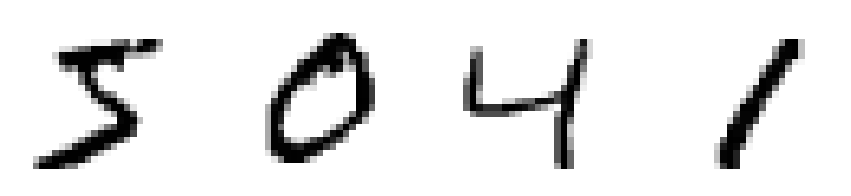

In [42]:
img = X[:4]
img = img.reshape(4,28,28)

fig, axs = plt.subplots(1, 4, figsize=(15,6))
for i in range(4):
  axs[i].imshow(img[i], cmap='binary',interpolation='nearest')
  axs[i].axis("off")

plt.show() 

На изображениях цифры `5, 0, 4, 1`. Сразу можно сказать, что у изображений можно нормализовать значение яркости пикселя, делать более четкие контуры, убирать лишнее пространство. По цифре `5` видно, что алгоритмы могут легко путать некоторые цифры, потому что они написаны от руки и даже человек не всегда сможет всё правильно классифицировать. 

Разобьём набор на тестовый и тренировочный. MNIST уже разделен на тренировочный и тестовый набор, как сказано выше. Дополнительно перемешаем тестовый набор данных 

In [43]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


## Бинарная классификация

Попробуем реализовать бинарную классификацию классическими алгоритмами, чтобы получить базовое качество для будущих моделей. 

Для начала обычим классификатор выявлять `5`. В качестве классификатора SGD, так как он хорошо справляется с большими объёмами данных.

In [44]:
y_train_5 = (y_train =='5')
y_test_5 = (y_test =='5')

In [45]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Протестируем на изображениях, которые мы выводили.

In [46]:
sgd_clf.predict(img.reshape(4,-1))

array([ True, False, False, False])

На изветсных нам изображзениях классификатор дал верный ответ. Оценим его качество на тренировочной выборке с помощью перекрестной проверки.

In [47]:
y_train_5.mean()

0.09035

In [48]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9638 , 0.94975, 0.96095])

Качество более 93%. Из-за того, что выборка сильно несбалансированна, всего около 9% пятёрок, метрика `accuracy` не подходит для адекватной оценки качества.
Лучше себя покажут метрики `'roc_auc','f1','precision','recall'`, помотрим на их разброс в зависимости от  

In [49]:
scoring = ['roc_auc','f1','precision','recall']
cross_validate(sgd_clf, X_train, y_train_5, cv=3, scoring=scoring)

{'fit_time': array([7.23324728, 7.10214472, 9.58516979]),
 'score_time': array([0.07021141, 0.06527758, 0.06506228]),
 'test_f1': array([0.76401565, 0.6203249 , 0.7951744 ]),
 'test_precision': array([0.92942109, 0.97738095, 0.7557328 ]),
 'test_recall': array([0.64858882, 0.45434422, 0.8389596 ]),
 'test_roc_auc': array([0.96976856, 0.95932918, 0.96994846])}

`roc_auc` достаточно стабильно показывает качество в райне 96-97%, значение метрики `f1` сильно колеблется, в зависимости от набора данных, что не позволяет стабильно адекватно оценивать качество модели.
Проверим качество этой модели на тестовой выборке.

In [50]:
roc_auc_score(y_test_5, sgd_clf.predict(X_test), average='weighted')

0.8899324203233347

Базовое `roc_auc` возьмём за 0.87. Проверим, какое качество покажет модель RandomForestClassifier

In [51]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_5)

RandomForestClassifier(random_state=42)

In [52]:
roc_auc_score(y_test_5, forest_clf.predict(X_test), average='weighted')

0.9369452469715679

Качество модели случайного леса значительно отличает от стохастического градиента. Попробуем ещё поднять качество этих алгоритмов, нормализовав данные на максимальное значение.

In [53]:
X_train_n = (X_train /  X_train.max()).copy()
X_test_n = (X_test /  X_train.max()).copy()

In [54]:
print(X_train_n.max(), X_test_n.max())

1.0 1.0


In [55]:
sgd_clf.fit(X_train_n, y_train_5)
forest_clf.fit(X_train_n, y_train_5)
print('Качество модели SGD',roc_auc_score(y_test_5, sgd_clf.predict(X_test_n), average='weighted'))
print('Качество модели RandomForest',roc_auc_score(y_test_5, forest_clf.predict(X_test_n), average='weighted'))

Качество модели SGD 0.9101753054034202
Качество модели RandomForest 0.9369452469715679


Ожидаемо, для линейной модели качество подросло до 0.89.

# Многоклассовая классификация

Есть 3 тактики построения такой классификации:
- Использовать классификаторы, способные разделять больш, чем 2 класса
- Использовать бинарные классификаторы со стратегией "один против всех"(OvA)
- Использовать бинарные классификаторы со стратегией "каждый против каждого"(OvO)

sklearn автоматически определяет, что мы используем многоклассовую классификацию и использует стратегию OvA для бинарных классификаторов, кроме метода опорных векторов.    
Применим те же алгоритм, но в случае многоклассовой классификации.


In [56]:
sgd_clf_mult = SGDClassifier(random_state=42)
sgd_clf_mult.fit(X_train, y_train.astype('int'))

SGDClassifier(random_state=42)

In [57]:
roc_auc_score(sgd_clf_mult.predict(X_test)

array([7, 2, 1, ..., 4, 5, 6])

Выведем матрицу ошибок и определим какие цифры путаются чаще

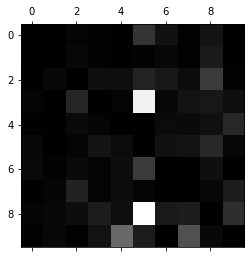

In [60]:
conf_m = confusion_matrix(y_test.astype('int'), sgd_clf_mult.predict(X_test))
norm_conf_m = conf_m / conf_m.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_m, 0)
plt.matshow(norm_conf_m, cmap='gray')

Заполнив глывную диагональ 0, мы оставили в матрице только ошибки. Видим, что SGD часто путает классифицирует `4`, как `9`, возможно из-за разных способов написания этой цифры. Также ошибки часто возникают при классификации `3` и `5`. В строке `9` много светлых квадратов, что говорит о большом количестве ложно положительных результатов. При этом сами девятки классифицировались довольно точно.   

# PyTorch

Создадим трехснолйную полносвязную нейронную сеть. Посмотрим какое качество она сможет показать на данном наборе.

In [61]:
from torch import nn
import torch
from torchvision import datasets, transforms

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

Для упрощения обучения нейронной, снова загрузим данные. Так как датасет изначально разбит на обучающий и тестовый, то все модели сравниваются в качестве на одих и тех-же данных. При выгрузке данных сформируем батчи по 32 изображения. Самиизображения нормализуем, приведя значения яркости пикселей к диапазону от -1, до 1.

In [62]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

В качестве метрики используем negative log likelihood loss, она хорошо подходт для решения задачь многоклассовой классификации.

In [63]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [64]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [-0.0053, -0.0053, -0.0053,  ..., -0.0053, -0.0053, -0.0053],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007]])


Оптимизатором в данной модели используем SGD.

In [65]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [66]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(32, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0158, -0.0222,  0.0195,  ...,  0.0345, -0.0211, -0.0293],
        [ 0.0121, -0.0016, -0.0283,  ..., -0.0100, -0.0165, -0.0301],
        [ 0.0162, -0.0083, -0.0186,  ..., -0.0343, -0.0272, -0.0137],
        ...,
        [ 0.0165, -0.0356, -0.0350,  ..., -0.0116, -0.0287, -0.0253],
        [-0.0169, -0.0289,  0.0139,  ...,  0.0019,  0.0203, -0.0316],
        [ 0.0309, -0.0355,  0.0010,  ..., -0.0175, -0.0200,  0.0061]],
       requires_grad=True)
Gradient - tensor([[ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0034, -0.0034, -0.0034,  ..., -0.0034, -0.0034, -0.0034],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        ...,
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        [ 0.0019,  0.0019,  0.0019,  ...,  0.0019,  0.0019,  0.0019]])


In [67]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0158, -0.0222,  0.0195,  ...,  0.0345, -0.0211, -0.0293],
        [ 0.0121, -0.0016, -0.0283,  ..., -0.0099, -0.0164, -0.0300],
        [ 0.0162, -0.0083, -0.0186,  ..., -0.0343, -0.0273, -0.0137],
        ...,
        [ 0.0165, -0.0356, -0.0350,  ..., -0.0116, -0.0287, -0.0253],
        [-0.0169, -0.0289,  0.0139,  ...,  0.0019,  0.0203, -0.0316],
        [ 0.0309, -0.0355,  0.0010,  ..., -0.0176, -0.0200,  0.0061]],
       requires_grad=True)


Запустим обучение - 20 эпох.

In [68]:
from time import time
time0 = time()
epochs = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {e} - Training loss: {running_loss/len(trainloader)}")
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5442788770357768
Epoch 1 - Training loss: 0.25469048287669815
Epoch 2 - Training loss: 0.18773534723122914
Epoch 3 - Training loss: 0.14861114405095577
Epoch 4 - Training loss: 0.12326566871404648
Epoch 5 - Training loss: 0.10549304984137416
Epoch 6 - Training loss: 0.09188183048802118
Epoch 7 - Training loss: 0.08126626476707557
Epoch 8 - Training loss: 0.07197220706834147
Epoch 9 - Training loss: 0.06608075941149145
Epoch 10 - Training loss: 0.05816989509103199
Epoch 11 - Training loss: 0.053897836486405386
Epoch 12 - Training loss: 0.050119156069060165
Epoch 13 - Training loss: 0.04492121666623279
Epoch 14 - Training loss: 0.04167759813455244
Epoch 15 - Training loss: 0.0384022954631752
Epoch 16 - Training loss: 0.0352665314878958
Epoch 17 - Training loss: 0.032685591064129646
Epoch 18 - Training loss: 0.02970027137869814
Epoch 19 - Training loss: 0.028114386502676645

Training Time (in minutes) = 3.769890824953715


Выведем в каких соотношениях модель предсказывает класс обекта.

In [69]:
def view_classify(img, ps):
    ''' Фукнция, печатающая изображение и вероятности классов
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 6


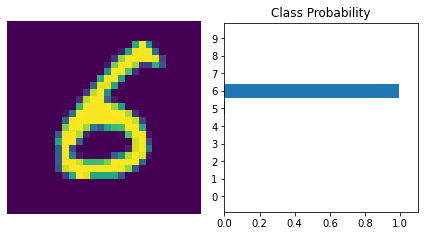

In [70]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Рассчитаем ошибку модели. Для простоты, используем метрику accuracy.

In [71]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)
        
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9802
